<a href="https://colab.research.google.com/github/opherdonchin/BSF_NSF2022/blob/main/BSF_NSF_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Questions for the discussion tonight



1.   Which signal drives skill learning?

Recalibration level is $x_r$ and strategic level is $x_s$. Total adaptation is $x = x_r + x_s$. Each responds to an error signal, $e_r$ and $e_s$, learning is

$
\begin{align}
x_{r, n+1} = A x_r + B e_r \\
x_{s, n+1} = A x_s + B e_s
\end{align}
$

Now, which of these signals drives skill learning? Is it $x_r$ and $x_s$, or $e_r$ and $e_s$, or $B_r e_r$ and $B_s e_s$?

2.   what sort of learning happens in the different probe trials. In reduced RT we have a theory but I'm not sure what the "state space" version of a generalization or a target jump trial would be.

3.   Let's say a short reaction time suppresses strategic adaptation. Do we still get the effects of strategic adaptation on skill? This is related to question  1: which signal actually changes skill.

4.   Let's say delays suppress recalibration? How does this affect adaptation and how does it affect skill learning?




In [1]:
!pip install ypstruct

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ypstruct: filename=ypstruct-0.0.2-py3-none-any.whl size=2971 sha256=183099ccb4f46de2ff338e2e4f2ddc6067b640127c6490a532581429ec900cd7
  Stored in directory: /root/.cache/pip/wheels/62/c0/62/97e51a118545a181245d8111048d46ad4fbd0c0078c6804218
Successfully built ypstruct


In [2]:
import numpy as np
import math
import random
import pandas as pd
from matplotlib import pyplot as plt
from ypstruct import *
from scipy.special import expit
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


In [3]:
plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (12,12)

# Ideas copied from the Jordan and Donchin grant


### Learning process and measures of skill

The idea of Donchin and Jordan is to measure the effect of different motor learning processes on the development of motor skill. They consider three motor learning processes: **strategic**, **recalibration**, and **reinforcement learning**.

**Recalibration** can be prevented by cursor delay. It asymptotes at a relative low value and saturates in rsponse to relatively small errors. **Strategic** processes can be prevented by limiting preparation time. **Reinforcement learning** can be controlled by controlling success rate. It is very slow. They propose manipulating each of these and see how skill learning is effected.

Skill development is measured along three dimensions: *preparation*, *generalization*, and *feedback*. *Preparation* is measured by the slope of the preparation / accuracy tradeoff function. *Generalization* is measured by adaptation in movement to new directions. *Feedback* is measured by response to perturbations.

**Recalibration** probably improves feedback processing and may improve motor preparation time. **Strategy** use increases *preparation* speed. It may also affect (increase?) generalization.**Reinforcement learning** may also contribute to *preparation* and *feedback* but less to generalization. 



# The structure of the task

Movements are made to 6 targets, spaced 60° apart. Reaction time will be controlled. Success windows (both for movement onset accuracy and for movement direction accuracy) will be manipulated to control success rate. Base success rate will be 70%. 

4 blocks in the experiment

- Familiarization, 300 movememnts, veridical feedback
- Baseline, 150 movements, veridical feedback, skill measures
  - I changed this to 160 so there would be 4 of each probe condition for each type of probe trial
- Rotation, 1200 movememnts, 30° rotation, skill measures
- Washout, 150 movements, no visual feedback, no strategy

Baseline and rotation blocks will be 30% probe trials: 10% for each of *preparation*, *generalization*, and *feedback*. 

- *Preparation* probe trials have RT of 100 ms, 200 ms, 300 ms, or 400 ms (compared to 1,000 ms in non-probe trials). Adaptation with shorter preparation time is more skill.
- *Generalization* probe trials have targets at ±10 or ±20. Greater generalization is more skill. 
- *Feedback* probe trials have target jump to ±10 or ±20 and we measure latency and accuracy of feedback corrections. Shorter latency and better accuracy mean more skill.



## Code for task structure

In [4]:
blocks = [{'name': 'familiarization', 'num_mvmt': 300,  'feedback': True,  'rotation': 0,  'probe': False, 'vision': True},
          {'name': 'baseline',        'num_mvmt': 160,  'feedback': True,  'rotation': 0,  'probe': True , 'vision': True},
          {'name': 'rotation',        'num_mvmt': 1200, 'feedback': True,  'rotation': 30, 'probe': True , 'vision': True},
          {'name': 'washout',         'num_mvmt': 150,  'feedback': False, 'rotation': 0,  'probe': False, 'vision': False},
          ]
num_blocks = len(blocks)

probe_types = ['preparation', 'generalization', 'feedback']
p_probe_per_type    = 0.1
num_probe_types = len(probe_types)
p_probe = num_probe_types*p_probe_per_type

probe_conditions = [
              [100, 200, 300, 400],
              [-20, -10, 10, 20],
              [-20, -10, 10, 20],
]
non_probe_condition = [600, 0, 0]
probe_variables = ['rt', 'target', 'jump']
num_conditions_per_probe = len(probe_conditions[0])

mvmt_list = list()
for block in blocks:
  num_mvmt = block['num_mvmt']
  probe_block = block['probe']
  if probe_block:
    num_probe_per_type = int(p_probe_per_type*num_mvmt)
    num_prob_total = num_probe_types*num_probe_per_type
    all_probe_mvmts = random.sample(range(num_mvmt), num_prob_total) # These are all the probe movements for all types
    # Then we separate it into three sets, one for each type
    probe_mvmts = [all_probe_mvmts[(i*num_probe_per_type):((i+1)*num_probe_per_type)] for i in range(num_probe_types)]

    num_per_condition = int(num_probe_per_type / num_conditions_per_probe)
    # This is supposed to generate a shuffling of the 4 probe conditions the appropriate number of times 
    probe_conditions_rand = list()
    for condition_list in probe_conditions:
      probe_conditions_rand.append(
          [
           condition for i in range(num_per_condition) for condition in random.sample(condition_list, len(condition_list))
           ]
           )

  for mvmt_num in range(num_mvmt):
    this_mvmt = dict()
    this_mvmt['block'] = block['name']
    this_mvmt['feedback'] = block['feedback']
    this_mvmt['rotation'] = block['rotation']

    this_mvmt['probe_type'] = ''
    this_mvmt['rt'] = non_probe_condition[0]
    this_mvmt['target'] = non_probe_condition[1]
    this_mvmt['jump'] = non_probe_condition[2]
    this_mvmt['vis'] = block['vision']
    if probe_block:
      # Get whether this is a probe trial by looking at all the enumerated probe trals
      probe_type_n = [i for (i, probe_mvmt_list) in enumerate(probe_mvmts) if mvmt_num in probe_mvmt_list]
 
      if probe_type_n:
        probe_type_n = probe_type_n[0]
        if mvmt_num in probe_mvmts[probe_type_n]:
           probe_condition = [c for (i, c) in enumerate(probe_conditions_rand[probe_type_n]) if probe_mvmts[probe_type_n][i] == mvmt_num][0]
        this_mvmt['probe_type'] = probe_types[probe_type_n]
        this_mvmt[probe_variables[probe_type_n]] = probe_condition
        this_mvmt['vis'] = False

    mvmt_list.append(this_mvmt)  


mvmt_table = pd.DataFrame(mvmt_list)

    


In [5]:
mvmt_table.head()

,block,feedback,rotation,probe_type,rt,target,jump,vis
0,familiarization,True,0,,600,0,0,True
1,familiarization,True,0,,600,0,0,True
2,familiarization,True,0,,600,0,0,True
3,familiarization,True,0,,600,0,0,True
4,familiarization,True,0,,600,0,0,True


# Define the model

## State update

The model will have two or three states. We'll start with a two state model with a recalibration process, $r$, and a strategic process, $s$. The actual movement will include motor error, $\epsilon$, and the perturbation, $p$. 

$
\begin{align}
x_n & = x_{r,n} + x_{s,n} \\
y_n & = x_n + p_n + \epsilon_n \\
\epsilon_n & \sim N(0, \sigma^2_{\epsilon})
\end{align}
$

We will assume that the recalibration process is sensitive to sensory prediction error, $x_n - y_n$, while the strategic process is sensitive to target error, $y_n$. Each has a learning, $B$, and forgetting, $A$, term and Eeach of them includes a noise term, $\eta$

$
\begin{align}
x_{r,n+1} & = A_r x_{r,n} - B_r (y_n - x_{s,n}) + \eta_{r,n} \\
x_{s,n+1} & = A_s x_{s,n} - B_s y_n + \eta_{s,n} \\
\eta_{r,n}, \eta_{s,n} & \sim N(0, \sigma^2_{\eta})
\end{align}
$



### Code for state update

In [6]:
def state_update(x: struct, phi, rho, p: struct, rot, vis):
  epsilon = random.normalvariate(0, p.sep)
  eta_r = random.normalvariate(0, p.seta)
  eta_s = random.normalvariate(0, p.seta) 
  xn = x.r*rho + x.s*phi
  hn = xn + epsilon
  yn = hn + rot
  x1 = struct()
  if vis:
    x1.r = p.Ar * x.r - p.Br * (yn - x.s*phi) + eta_r
    x1.s = p.As * x.s - p.Bs * yn + eta_s
  else:
    x1.r = p.Ar * x.r + eta_r
    x1.s = p.As * x.s + eta_s

  return x1, yn, hn

## Skill learning

According to the grant, skills are learned in response to each process. That is, recalibration will cause increased skill and strategic adaptation will aso cause increased skill. However, there are three skill processes, $S$, and each of them will be increased diferently by the two adaptation processes: *preparation*, $S_P$, *generatization*, $S_G$, and *feedback*, $S_F$. .

There is some question as to what **in the adaptation process** actually drives the skill learning. The easiest for me to imagine is that the rate of adaptation is driving the skill learning: $S_r = B_r (x_n - y_n)$ and $S_s = B_s y_n$.

I'll also magically assume that skill only increases. That's probably a dumb assumption. We weren't clear in the grant.

$
\begin{align}
\Delta S_P & = \alpha_{P,r} S_r^2 + \alpha_{P,s} S_s^2 \\
\Delta S_G & = \alpha_{G,r} S_r^2 + \alpha_{G,s} S_s^2 \\
\Delta S_F & = \alpha_{F,r} S_r^2 + \alpha_{F,s} S_s^2
\end{align}
$

We could use these to drive the skill.

We will then use a logistic / logit transform to keep the skill between $0$ and $1$. To make skill increase early and then plateau, let's start with a half-expit (slope of 1 at the beginning), although we could shift the beginning point to anywhere to have skill start to really increase only after some practice.


### Code for skill learning



In [7]:
def skill_learn(S, x: struct, p: struct, y):
  S1 = struct()
  Sr = ( p.Br * (x.r + x.s - y) )**2
  Ss = ( p.Bs * y )**2
  a = p.alpha
  S1.P = S.P + a.Pr * Sr + a.Ps * Ss
  S1.G = S.G + a.Gr * Sr + a.Gs * Ss
  S1.F = S.F + a.Fr * Sr + a.Fs * Ss
  return S1

In [8]:
def transform_skill(S, S0):
  # This will produce a partial sigmoid so that sigmoid is stretched and translated 
  # the sigmoid domain from S0 to Inf which ranges from expit(S0) to 1 is mapped
  # to the domain 0 to Inf and ranges from 0 to 1 
  return (expit(S+S0)-expit(S0))/(1-expit(S0))

## Probe trials

Probe trials manipulate a specific aspect of task condition and measure the effect on movement direction.

### *Preparation* probes affect **strategic**

In *preparation* trials, the reaction time is manipulated. Reduced reaction time limits expression of **strategic** adaptation. We model this relationship as piecewise linear:

$
\begin{align}
x_{s}(RT) & = x_{s,\infty} \phi(RT) \\
\phi(RT) & = \begin{cases}
1 & \text{if } RT_{\infty} \le RT \\
\phi_0 + \frac{RT - RT_0}{RT_{\infty}  - RT_0}(1-\phi_0) & \text{if } RT_0 \le RT \le RT_{\infty} \\
\phi_0 & \text{if } RT \le RT_0
\end{cases}
\end{align}
$

Skill learning will increase $\phi_0$ and reduce $RT_0$ causing the preparation / performance function to flatten.

#### Code for effect of RT on strategic

In [9]:
def preparation_phi(RT, SP, p:struct):
  eS = transform_skill(SP, p.S0.P)
  phi0 = p.min_phi0 + eS*(p.max_phi0 - p.min_phi0)
  RT0 = p.max_RT0 + eS*(p.min_RT0 - p.max_RT0)
  RTinf = p.RTinf
  RT = np.minimum(np.maximum(RT, RT0), RTinf)
  return phi0 + (1-phi0)*(RT-RT0)/(RTinf - RT0)
  

### *Generalization* probes affect **recalibration**
In *generalization* trials, movements are made to a target that is different from the trained targets. We assume **strategic** adaptation is applied quite broadly and is not affected by the difference. In contrast, **recalibration** will be reduced as a function of the distance from the trained target.

$
\begin{align}
x_r(\theta) & = x_{r,0} \rho(\theta) \\
\rho(\theta) &= e^{- \frac{\theta^2}{\rho_0^2}}
\end{align}
$

In this formulation, $\rho_0$ gives the distance from the training target where **recalibration** falls to $\frac{1}{3}$ of its maximum. Skill will increase $\rho_0$.

#### Code for effect of generalization on recalibration

In [10]:
def generalization_rho(target, SG, p:struct):
  eS = transform_skill(SG, p.S0.G)
  rho0 = p.min_rho0 + eS*(p.max_rho0 - p.min_rho0)
  return np.exp(target*target / (rho0*rho0))

### *Feedback* probes affect movement

In *feedback* probe trials, the target jumps during the movement. We can then measure the extent of correction following the jump. That is, we are assuming that if the feedback is processed very slowly, the movement will be identical to a movement to the original target. If the feedback is processed very quickly, the movement will be identical to a movement to the target that was jumped to. 

Thus, the outcome of the trial can be expressed in terms of the fraction of the distance the reach is between these two possibilities.

$
x = x_{\text{original}} + (x_{\text{jump}} - x_{\text{original}}) \tau
$

With the value of $\tau$ increasing with skill

#### Code for effect of feedback on actual movement

In [11]:
def feedback_tau(SF, p):
  eS = transform_skill(SF, p.S0.F)
  return p.min_tau + eS*(p.max_tau - p.min_tau)

# Setting values of all constants

Including:
- Parameters of state: $A$, $B$, $\sigma_{\epsilon}$, $\sigma_{\eta}$, 
- Parameters of skill development: $\alpha_{P,r}$, $\alpha_{P,s}$, $\alpha_{G,r}$, $\alpha_{G,s}$, $\alpha_{F,r}$, $\alpha_{F,s}$.
- Parameters of skill expression:
  - Preparation: $\phi_{0,\text{min}}$, $\phi_{0,\text{max}}$, $RT_{0,\text{min}}$, $RT_{0,\text{max}}$
  - Generalization: $\rho_{0,\text{min}}$, $\rho_{0,\text{max}}$
  - Feedback: $\tau_{\text{min}}$, $\tau_{\text{max}}$

In [12]:
# Parameter struct
p0 = struct()

## Parameters of state

In [13]:
p0.Ar = 0.98
p0.Br = 0.01
p0.As = 0.8
p0.Bs = 0.2
p0.sep = 0.001
p0.seta = 0.001
p0.x0 = struct()
p0.x0.r = random.normalvariate(0, p0.seta)
p0.x0.s = random.normalvariate(0, p0.seta)

## Parameters of skill development

In [138]:
p0.alpha = struct()
p0.alpha.Pr = 1e-4
p0.alpha.Ps = 7e-4
p0.alpha.Gr = 2e-4
p0.alpha.Gs = 2e-4
p0.alpha.Fr = 12e-4
p0.alpha.Fs = 5e-4
# Initial values of skill
p0.S0 = struct() 
p0.S0.P = -3
p0.S0.G = 0
p0.S0.F = -1

## Parameters of skill expression

In [139]:
p0.min_phi0 = 0.0
p0.max_phi0 = 0.7
p0.min_RT0 = 350
p0.max_RT0 = 150
p0.RTinf = 500
p0.min_rho0 = 20
p0.max_rho0 = 50
p0.min_tau = 0.05
p0.max_tau = 0.95


# Simulating the control condition


## Code for simulation

In [140]:
def run_experiment(mvmt_table, p0):
  x = struct()
  x.r = p0.x0.r
  x.s = p0.x0.s

  S = struct()
  S.P = p0.S0.P
  S.G = p0.S0.G
  S.F = p0.S0.F

  mvmt_table = mvmt_table.copy()
  mvmt_table = mvmt_table.assign(
      xs=np.nan, xr=np.nan,
      SP=np.nan, SG=np.nan, SF=np.nan,
      y=np.nan, h=np.nan,
      phi=np.nan, rho=np.nan, tau=np.nan)
  for mvmt_num, mvmt in mvmt_table.iterrows():
    rot = mvmt.rotation

    mvmt_table.loc[mvmt_num, ["xr", "xs"]] = [x.r, x.s]
    mvmt_table.loc[mvmt_num, ["SP", "SG", "SF"]] = [S.P, S.G, S.F]
    mvmt_table.loc[mvmt_num, ["eSP", "eSG", "eSF"]] = (
                                                        transform_skill(S.P, p0.S0.P),
                                                        transform_skill(S.G, p0.S0.G),
                                                        transform_skill(S.F, p0.S0.F),
    )

    # Get current trial conditions
    rt = mvmt.rt
    target = mvmt.target
    vis = mvmt.vis

    # Set behavior according to skill and conditions
    p = p0
    phi = preparation_phi(rt, S.P, p)
    rho = generalization_rho(target, S.G, p)
    tau = feedback_tau(S.F, p)

    
    # User current behavior to update state
    x1,yn,hn = state_update(x, phi, rho, p, rot, vis)
    S1 = skill_learn(S, x, p, yn)

    if mvmt.probe_type == 'feedback':
      jump_target = mvmt.jump
      
      rho_jump = generalization_rho(jump_target, S.G, p)
      x_jump,y_jump, h_jump = state_update(x, phi, rho_jump, p, rot, vis)
      
      y_jump = y_jump + jump_target
      h_jump = h_jump + jump_target
      yn = yn + tau*(y_jump - yn)
      hn = hn + tau*(h_jump - hn)
   

    mvmt_table.loc[mvmt_num, ["y", "h"]] = [yn, hn]
    mvmt_table.loc[mvmt_num, ["phi", "rho", "tau"]] = [phi, rho, tau]
    

    # Update state with new values
    x = x1
    S = S1
  return mvmt_table

mvmt_table = run_experiment(mvmt_table, p0)

In [141]:
mvmt_table.head()

,block,feedback,rotation,probe_type,rt,target,jump,vis,xs,xr,...,SG,SF,y,h,phi,rho,tau,eSP,eSG,eSF
0,familiarization,True,0,,600,0,0,True,-0.000015,-0.002038,...,0.000000e+00,-1.0,-0.001689,-0.001689,1.0,1.0,-0.134342,-0.047191,0.000000e+00,-0.204824
1,familiarization,True,0,,600,0,0,True,-0.000302,-0.001790,...,2.283110e-11,-1.0,-0.002454,-0.002454,1.0,1.0,-0.134342,-0.047191,1.141554e-11,-0.204824
2,familiarization,True,0,,600,0,0,True,0.000571,-0.001565,...,7.100237e-11,-1.0,0.000310,0.000310,1.0,1.0,-0.134342,-0.047191,3.550116e-11,-0.204824
3,familiarization,True,0,,600,0,0,True,-0.000392,-0.002891,...,7.180453e-11,-1.0,-0.003205,-0.003205,1.0,1.0,-0.134342,-0.047191,3.590239e-11,-0.204824
4,familiarization,True,0,,600,0,0,True,-0.000191,-0.002951,...,1.540042e-10,-1.0,-0.001480,-0.001480,1.0,1.0,-0.134342,-0.047191,7.700218e-11,-0.204824


## Plots of simulated data

(<Figure size 864x864 with 3 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7eff97307a90>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7eff971cdd10>))

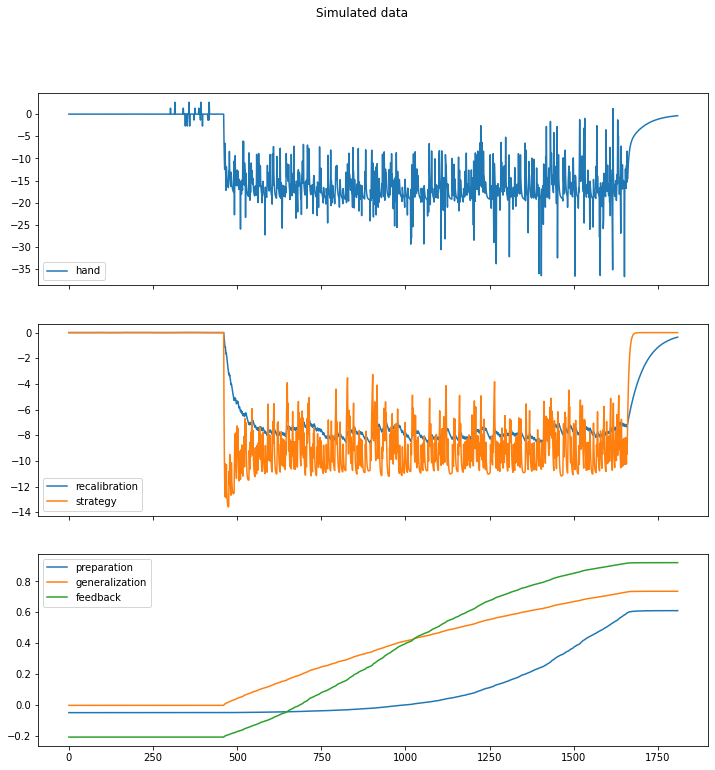

In [142]:
def plot_learning_curves(mvmt_table):
  fig, (axh, axx, axS) = plt.subplots(3, sharex=True)
  fig.suptitle('Simulated data')
  axh.plot(mvmt_table["h"], label="hand")
  axh.legend()
  axx.plot(mvmt_table["xr"], label="recalibration")
  axx.plot(mvmt_table["xs"], label="strategy")
  axx.legend()
  axS.plot(mvmt_table["eSP"], label="preparation")
  axS.plot(mvmt_table["eSG"], label="generalization")
  axS.plot(mvmt_table["eSF"], label="feedback")
  axS.legend()
  return fig, (axh, axx, axS)

plot_learning_curves(mvmt_table)

# Show the adaptation and skill learning for simulated data

The grant describes three measures of adaptation and three measures of skill.



## Adaptation measures

The adaptation measures are: *learning rate*, the average movement direction in the first 40 rotation movements; *asymptote*, the average movement direction in the last 40 rotation movements; *aftereffect*, the average movement direction in the first 40 washout trials.

### Code for defining adaptaton measures

In [143]:
def measure_adaptation(mvmt_table):
  rotation_trials = mvmt_table[mvmt_table["block"] == 'rotation']
  washout_trials = mvmt_table[mvmt_table["block"] == 'washout']
  learning_rate_trials = rotation_trials.iloc[:40, :]
  asymptote_trials = rotation_trials.iloc[-40:, :]
  aftereffect_trials = washout_trials.iloc[:40, :]

  lr = learning_rate_trials["h"].mean()
  asmp = asymptote_trials["h"].mean()
  after = aftereffect_trials["h"].mean()
  return lr, asmp, after



In [144]:
measure_adaptation(mvmt_table)

(-13.806816746019752, -15.306222204257761, -5.89035431630124)

## Skill measures

All skill measures are measured in 4 epochs and 3 measures of skill. The epochs are: baseline, early (first 400 rotation trials), middle (middle 400), and late (last 400). 

The measures of skill are *preparation*, *generalization*, and *feedback*. *Preparation* is measured of the slope of movement direction against reaction time. *Generalization* is measured as the width of a Gaussian fit to movements in direction around the target direction. *Feedback* is measured as the percentage of the full correction to target made during the movement. 


### Code for getting the probe trials

In [145]:
from pandas.core.frame import DataFrame
skill_epochs = pd.DataFrame(
    {'name': ["baseline", "early", "middle", "late"],
     'block': ["baseline", "rotation", "rotation", "rotation"],
     "mvmt_nums": [range(160), range(400), range(400,800), range(800,1200)], 
    }
)
skill_epochs.set_index('name')

def get_probe_trials_by_epoch(mvmt_table: DataFrame, epoch, probe_type):
  block_table = mvmt_table[mvmt_table["block"] == epoch["block"]]
  epoch_table = block_table.iloc[epoch["mvmt_nums"],:]
  probe_table = epoch_table.loc[epoch_table["probe_type"] == probe_type]
  return probe_table

In [146]:
get_probe_trials_by_epoch(mvmt_table, skill_epochs.iloc[0,:], "preparation").head()

,block,feedback,rotation,probe_type,rt,target,jump,vis,xs,xr,...,SG,SF,y,h,phi,rho,tau,eSP,eSG,eSF
314,baseline,True,0,preparation,400,0,0,False,-0.002912,0.000928,...,1.153523e-08,-1.0,-0.000026,-0.000026,0.712598,1.0,-0.134342,-0.047191,5.767614e-09,-0.204824
322,baseline,True,0,preparation,100,0,0,False,-0.000527,-0.000595,...,1.161673e-08,-1.0,0.000575,0.000575,-0.033034,1.0,-0.134342,-0.047191,5.808363e-09,-0.204824
343,baseline,True,0,preparation,200,0,0,False,-0.000416,0.007908,...,1.891016e-08,-1.0,0.006867,0.006867,0.137793,1.0,-0.134342,-0.047191,9.455080e-09,-0.204824
355,baseline,True,0,preparation,200,0,0,False,-0.004392,0.007391,...,2.876086e-08,-1.0,0.007203,0.007203,0.137793,1.0,-0.134342,-0.047191,1.438043e-08,-0.204824
356,baseline,True,0,preparation,400,0,0,False,-0.003413,0.007440,...,2.917632e-08,-1.0,0.004005,0.004005,0.712598,1.0,-0.134342,-0.047191,1.458816e-08,-0.204824


### Preparation
*Preparation* is measured as the slope of the relationship between preparation time and error.

In [147]:
linear_regression = LinearRegression()
def get_preparation_measure(probes):
  condition = probes["rt"].to_numpy().reshape(-1,1)
  h = probes["h"].to_numpy().reshape(-1,1)
  reg = linear_regression.fit(condition, h)
  return reg.coef_[0][0]

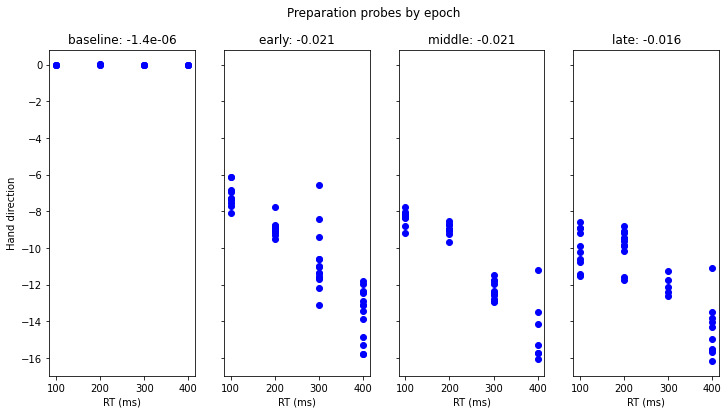

In [148]:
def plot_preparation_by_epoch(mvmt_table, skill_epochs):
  fig, ax = plt.subplots(1,4, sharey=True, figsize=(12,6))
  fig.suptitle('Preparation probes by epoch')
  for i, epoch in skill_epochs.iterrows():
    probes = get_probe_trials_by_epoch(mvmt_table, epoch, 'preparation')
    measure = get_preparation_measure(probes)
    ax[i].plot(probes["rt"], probes["h"], 'bo')
    ax[i].set_xlabel('RT (ms)')
    ax[i].set_title(f'{epoch["name"]}: {measure:.2}')

  ax[0].set_ylabel('Hand direction')

plot_preparation_by_epoch(mvmt_table, skill_epochs)

### Generalization

Generalization is measures as the width of a gaussian fit

In [149]:
def gaussian(x, *p):
  A, mu, sigma = p
  return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def get_generalization_measure(probes, non_probes):
  mvmts = pd.concat([probes, non_probes])

  condition = mvmts["target"].to_numpy()
  y = mvmts["y"].to_numpy()
  max_y = [y1 for y1 in y if abs(y1) == np.max(abs(y))][0]

  p0 = (max_y, 0, 10)
  try:
    coeff, var_matrix = curve_fit(gaussian, condition, y, p0=p0)
  except:
    coeff = [np.nan,np.nan,np.nan]
  return coeff[2]

In [150]:
probes = get_probe_trials_by_epoch(mvmt_table, skill_epochs.iloc[1,:], 'generalization')
non_probes = get_probe_trials_by_epoch(mvmt_table, skill_epochs.iloc[1,:], '')
g = get_generalization_measure(probes, non_probes)
print(g)

17.88123026249053


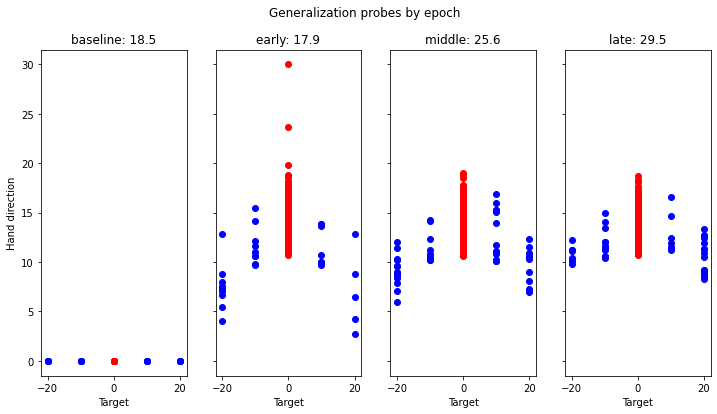

In [151]:
def plot_generalization_by_epoch(mvmt_table, skill_epochs):
  fig, ax = plt.subplots(1,4, sharey=True, figsize=(12,6))
  fig.suptitle('Generalization probes by epoch')
  for i, epoch in skill_epochs.iterrows():
    probes = get_probe_trials_by_epoch(mvmt_table, epoch, 'generalization')
    non_probes = get_probe_trials_by_epoch(mvmt_table, epoch, '')
    
    measure = get_generalization_measure(probes, non_probes)
    ax[i].plot(probes["target"], probes["y"], 'bo')
    ax[i].plot(non_probes["target"], non_probes["y"], 'ro')
    ax[i].set_xlabel('Target')
    ax[i].set_title(f'{epoch["name"]}: {measure:.1f}')

  ax[0].set_ylabel('Hand direction')

plot_generalization_by_epoch(mvmt_table, skill_epochs)


### Feedback

The feedback response has two dimensions. One is the latency to a change in the direction and the other is the percentage of the difference between movements to the original target and movements to the generalization target.

In [152]:
def get_feedback_measure(fb_probes, gnl_probes, non_probes):
  jump_targets = fb_probes.jump.unique()
  non_probe_mean = np.mean(non_probes["h"])
  compensation_list = list()
  for condition in jump_targets:
    fb = fb_probes.loc[fb_probes["jump"]==condition,"h"]
    fb_mean = np.mean(fb)
    gnl = gnl_probes.loc[gnl_probes["target"]==condition,"h"] + gnl_probes.loc[gnl_probes["target"]==condition,"target"]
    gnl_mean = np.mean(gnl)
    compensation = (fb_mean - non_probe_mean) / (gnl_mean - non_probe_mean)
    compensation_list.append(compensation)
  
  return np.mean(compensation)


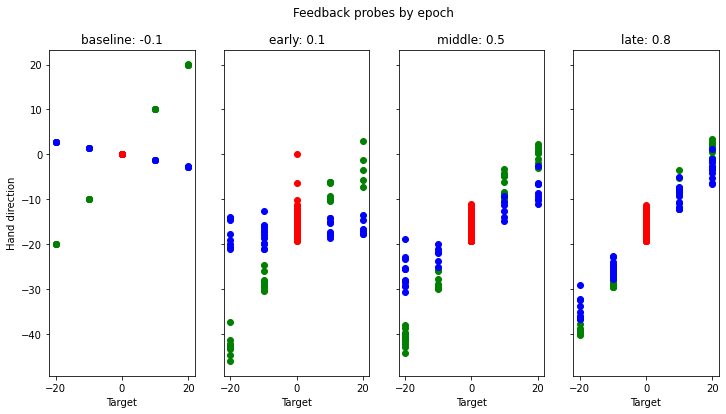

In [153]:
def plot_feedback_by_epoch(mvmt_table, skill_epochs):
  fig, ax = plt.subplots(1,4, sharey=True, figsize=(12,6))
  fig.suptitle('Feedback probes by epoch')
  for i, epoch in skill_epochs.iterrows():
    fb_probes = get_probe_trials_by_epoch(mvmt_table, epoch, 'feedback')
    gnl_probes = get_probe_trials_by_epoch(mvmt_table, epoch, 'generalization')
    non_probes = get_probe_trials_by_epoch(mvmt_table, epoch, '')
    measure = get_feedback_measure(fb_probes, gnl_probes, non_probes)

    ax[i].plot(non_probes["target"], non_probes["h"], 'ro')
    ax[i].plot(gnl_probes["target"], gnl_probes["h"]+gnl_probes["target"], 'go')
    ax[i].plot(fb_probes["jump"], fb_probes["h"], 'bo')
    ax[i].set_xlabel('Target')
    ax[i].set_title(f'{epoch["name"]}: {measure:.1f}')

  ax[0].set_ylabel('Hand direction')

plot_feedback_by_epoch(mvmt_table, skill_epochs)

# Experiment 1

Experiment 1 has two groups: low RT (150 ms) and high RT (350 ms).

In [ ]:
groups = pd.DataFrame(
    {'name': ['low RT', 'high RT'],
     'rt': [100, 400]}
)


exp1_mvmt_tables = list()
for i,group in groups.iterrows():
  group_mvmt_table = mvmt_table.copy()
  selected_blocks = group_mvmt_table['block'].isin(['baseline', 'rotation', 'washout'])
  selected_movements = group_mvmt_table["probe_type"] != 'preparation'
  group_mvmt_table.loc[selected_blocks & selected_movements, "rt"] = group["rt"]

  group_mvmt_table = run_experiment(group_mvmt_table, p0)
  exp1_mvmt_tables.append(group_mvmt_table)


(<Figure size 864x864 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe48917f810>,
       dtype=object))

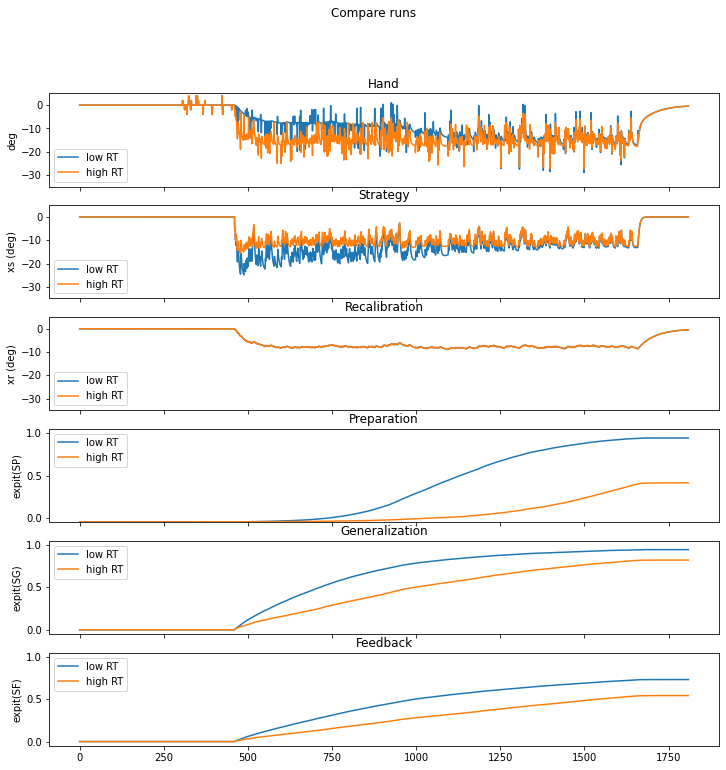

In [ ]:
def plot_learning_curve_compare(mvmt_tables, table_names):
  plot_names = ('Hand', 'Strategy', 'Recalibration', 'Preparation', 'Generalization', 'Feedback')
  plot_variables = ('h', 'xs', 'xr', 'eSP', 'eSG', 'eSF')
  plot_ylabels = ('deg', 'xs (deg)', 'xr (deg)', 'expit(SP)', 'expit(SG)', 'expit(SF)')
  plot_ylims = ([-35, 5], [-35, 5], [-35, 5], [-0.05, 1.05], [-0.05, 1.05], [-0.05, 1.05])

  num_plots = len(plot_names)
  fig, ax = plt.subplots(num_plots, sharex=True)
  fig.suptitle('Compare runs')

  plot_specs = zip(plot_names, plot_variables, plot_ylabels, plot_ylims)
  for v_i, (v_name, v, ylabel, ylim) in enumerate(plot_specs):
    for t_i, (t_name, t) in enumerate(zip(table_names, mvmt_tables)):
      ax[v_i].plot(t[v], label=t_name)
    ax[v_i].set_title(v_name)
    ax[v_i].set_ylabel(ylabel)
    ax[v_i].set_ylim(ylim)
    ax[v_i].legend()
  return fig, ax

plot_learning_curve_compare(exp1_mvmt_tables, groups["name"].to_numpy())

# Experiment 2

Experiment 2 has two groups: no delay and 500 ms delay